In [3]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, strategies
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(strategies)

<module 'libs.strategies' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/strategies.py'>

In [4]:
import os
import math
import pandas as pd
from pathlib import Path
import shutil                     

# pip install alpaca-py pandas pytz
from datetime import datetime, timedelta
import time
import os
import pandas as pd
import pytz
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest, StockQuotesRequest
from alpaca.data.timeframe import TimeFrame

import matplotlib.pyplot as plt
import seaborn as sns

# from eodhd import APIClient

In [6]:
KEY = os.getenv('ALPACA_KEY_live')
SECRET = os.getenv('ALPACA_SECRET_live')

KEY, SECRET

(None, None)

In [1]:
import sys, importlib.util
print("sys.executable:", sys.executable)
print("sys.path[:5]:", sys.path[:5])
print("find_spec('alpaca'):", importlib.util.find_spec("alpaca"))
# show pip info from the same interpreter
import subprocess, json
proc = subprocess.run([sys.executable, "-m", "pip", "show", "alpaca-py"], capture_output=True, text=True)
print("pip show alpaca-py output:")
print(proc.stdout or proc.stderr)


sys.executable: /usr/bin/python
sys.path[:5]: ['/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages']
find_spec('alpaca'): ModuleSpec(name='alpaca', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7612b4096900>, origin='/usr/local/lib/python3.12/dist-packages/alpaca/__init__.py', submodule_search_locations=['/usr/local/lib/python3.12/dist-packages/alpaca'])
pip show alpaca-py output:
Name: alpaca-py
Version: 0.43.2
Summary: The Official Python SDK for Alpaca APIs
Home-page: 
Author: Rahul Chowdhury
Author-email: rahul.chowdhury@alpaca.markets
License: Apache-2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: msgpack, pandas, pydantic, requests, sseclient-py, websockets
Required-by: 



In [3]:
import sys, pkgutil
print("Python executable:", sys.executable)
print("sys.path[0:5]:", sys.path[:5])
print("pkgutil.find_loader('alpaca'):", pkgutil.find_loader("alpaca"))


Python executable: /usr/bin/python
sys.path[0:5]: ['/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages']
pkgutil.find_loader('alpaca'): None


/tmp/ipykernel_164/77127267.py:4: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  print("pkgutil.find_loader('alpaca'):", pkgutil.find_loader("alpaca"))


In [2]:
#########################################################################
# 1 · helper – split the full span into equal-length chunks                   
#########################################################################
def date_chunks(start: dt.date, end: dt.date, chunk_len: int):
    """
    Yields (chunk_start, chunk_end) inclusive date tuples no longer than chunk_len.
    """
    cur = start
    while cur <= end:
        nxt = cur + dt.timedelta(days=chunk_len - 1)
        yield (cur, min(nxt, end))
        cur = nxt + dt.timedelta(days=1)


In [3]:
def safe_get(url, tries=5, pause=2):
    """Attempts to perform a GET request with retries."""
    for k in range(tries):
        try:
            r = requests.get(url, timeout=60)
            r.raise_for_status()
            return r
        except requests.RequestException as e:
            print(f"  ⚠️  Error: {e} (retry {k+1}/{tries})")
            if k == tries - 1:
                raise
            time.sleep(pause * (k + 1))  # Exponential-ish back-off


In [4]:
###############################################################################
# 2 · one call = one CSV                                                      #
###############################################################################
def fetch_chunk(stock, d0, d1, api_key, out_dir):
    """Fetches one 1-minute chunk and saves it to disk; returns Path."""
    et = pytz.timezone("US/Eastern")
    start_et = et.localize(dt.datetime.combine(d0, dt.time()))
    end_et   = et.localize(dt.datetime.combine(d1 + dt.timedelta(days=1), dt.time()))
    url = (
        f"https://eodhd.com/api/intraday/{stock}.US"
        f"?interval=1m&api_token={api_key}&fmt=json"
        f"&from={int(start_et.astimezone(pytz.utc).timestamp())}"
        f"&to={int(end_et.astimezone(pytz.utc).timestamp())}"
    )
    fname = f"{stock}_{d0:%Y%m%d}_{d1:%Y%m%d}.csv"
    path  = Path(out_dir) / fname
    print(f"  → downloading chunk {fname}")
    
    # Use safe_get if desired. Here use requests.get() directly.
    response = requests.get(url, timeout=60)
    response.raise_for_status()
    pd.DataFrame(response.json()).to_csv(path, index=False)
    return path

In [5]:

###############################################################################
# 3 · wrapper for ONE ticker                                                  #
###############################################################################
def download_and_merge(stock, api_key, start_date, chunk_days, output_dir):
    # Create/ensure output directories.
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    archive_dir = output_dir / "old"
    archive_dir.mkdir(exist_ok=True)

    start = dt.datetime.strptime(start_date, "%Y-%m-%d").date()
    today = dt.date.today()

    # Construct an initial merged file name (using the provided range).
    # This check is optional—if a merged file exists, we skip processing.
    initial_name = f"{stock}_{start:%Y%m%d}_{today:%Y%m%d}.csv"
    initial_path = output_dir / initial_name
    if initial_path.exists():
        print(f"Merged file already exists for {stock} at {initial_path}. Skipping.")
        return

    # --- Step A · download every chunk --------------------------------------
    csv_paths = []
    for d0, d1 in date_chunks(start, today, chunk_days):
        try:
            p = fetch_chunk(stock, d0, d1, api_key, output_dir)
            csv_paths.append(p)
            time.sleep(1)  # small pause between calls if needed
        except Exception as e:
            print(f"Chunk {d0}–{d1} failed: {e}")

    if not csv_paths:
        print("No data downloaded for", stock)
        return

    # --- Step B · merge chronologically -------------------------------------
    dfs = []
    for p in sorted(csv_paths):
        try:
            df = pd.read_csv(p, parse_dates=["datetime"])
            df.set_index("datetime", inplace=True)
            dfs.append(df)
        except Exception as e:
            print(f"Error reading {p}: {e}")
    if not dfs:
        print("No chunk files parsed for", stock)
        return

    merged = pd.concat(dfs).sort_index()
    # Retrieve the actual earliest and latest dates from the merged data.
    earliest_date = merged.index.min()
    latest_date   = merged.index.max()

    # Build the final filename based on the actual data range.
    final_name = f"{stock}_{earliest_date.strftime('%Y%m%d')}_{latest_date.strftime('%Y%m%d')}.csv"
    final_path = output_dir / final_name
    merged.to_csv(final_path)
    print("Merged file saved to", final_path)

    # --- Step C · archive chunk files ---------------------------------------
    for p in csv_paths:
        shutil.move(str(p), str(archive_dir / p.name))
    print(f"Archived {len(csv_paths)} chunk files for {stock}.")


In [6]:
api_key = os.getenv('EODHD_API_KEY')

stocks = [
    "SPY",    # S&P 500 ETF – broad market exposure
    "AAPL",   # Apple Inc. – highly liquid, long trading history
    "MSFT",   # Microsoft – blue-chip tech leader
    "AMZN",   # Amazon.com – high volume & growth
    "NVDA",   # NVIDIA – volatile, tech/AI leader
    "GOOGL",  # Alphabet Inc. – robust tech giant
    "META",   # Meta Platforms – social media & tech
    "TSLA",   # Tesla Inc. – dynamic price action (data available since IPO)
    "BRK.B",  # Berkshire Hathaway – diversified, stable long-term
    "JPM",    # JPMorgan Chase – financial powerhouse
    "V",      # Visa Inc. – global payments leader
    "UNH",    # UnitedHealth Group – healthcare giant
    "HD",     # Home Depot – retail leader
    "PG",     # Procter & Gamble – consumer staples stalwart
    "KO",     # Coca-Cola – defensive consumer stock
    "DIS",    # Walt Disney – strong media/entertainment
    "XOM",    # ExxonMobil – major energy company
    "VZ",     # Verizon Communications – telecom giant
    "INTC",   # Intel – key semiconductor player
    "CSCO",   # Cisco Systems – solid networking company
    "PFE",    # Pfizer – pharmaceutical heavyweight
    "CVX",    # Chevron – another energy benchmark
    "MRK",    # Merck & Co. – healthcare and biotech
    "WMT",    # Walmart – retail behemoth
    "BA",     # Boeing – aerospace & defense
    "GS",     # Goldman Sachs – leading investment bank
    "IBM",    # IBM – longstanding technology provider
    "WFC",    # Wells Fargo – major bank
    "C",      # Citigroup – global financial services
    "QCOM",   # Qualcomm – leader in wireless tech
    "ADBE",   # Adobe – creative and digital media software
    "CRM",    # Salesforce – prominent cloud-based software
    "NFLX",   # Netflix – streaming/media innovator
    "ORCL",   # Oracle – enterprise software giant
    "DIA",    # DIA – Dow Jones Industrial Average ETF
    "QQQ",    # QQQ – Nasdaq 100 ETF with tech-heavy exposure
    "HON",    # Honeywell International – diversified industrial
    "MCD",    # McDonald’s – global quick-service restaurant leader
    "GE",     # General Electric – diversified conglomerate
    "UPS",    # United Parcel Service – logistics and delivery
    "LOW",    # Lowe's Companies – home improvement leader
]



start_date = "2004-01-01"

max_allow_days = 120

output_dir="Intraday stocks"

In [7]:
###############################################################################
# =============================== run ========================================#
###############################################################################

for s in stocks:
    print(f"\n=== {s} ===")
    download_and_merge(s, api_key=api_key, start_date=start_date, chunk_days=max_allow_days, output_dir=output_dir)




=== SPY ===
  → downloading chunk SPY_20040101_20040429.csv
Chunk 2004-01-01–2004-04-29 failed: 401 Client Error: Unauthorized for url: https://eodhd.com/api/intraday/SPY.US?interval=1m&api_token=None&fmt=json&from=1072933200&to=1083297600
  → downloading chunk SPY_20040430_20040827.csv
Chunk 2004-04-30–2004-08-27 failed: 401 Client Error: Unauthorized for url: https://eodhd.com/api/intraday/SPY.US?interval=1m&api_token=None&fmt=json&from=1083297600&to=1093665600
  → downloading chunk SPY_20040828_20041225.csv


KeyboardInterrupt: 

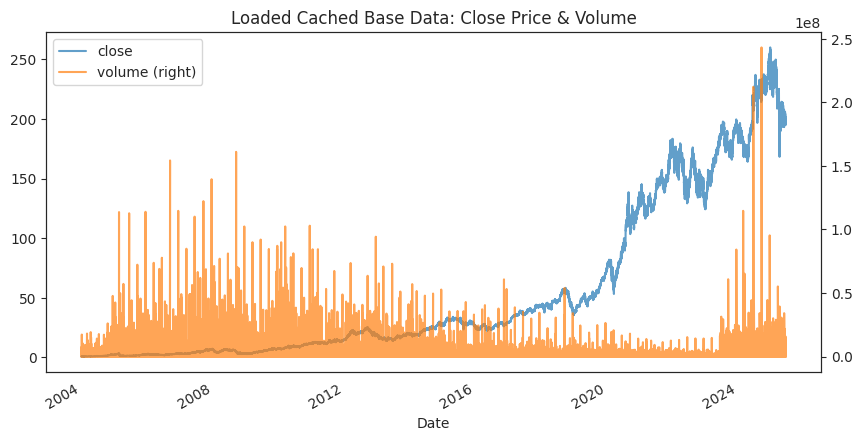

,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764439,0.764132
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764439,0.764132
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764439,0.764132
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764439,0.764132
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764439,0.764132
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.854400,196.775600
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.714300,196.635700
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.709300,196.630700
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.279200,196.200800


In [5]:
df = pd.read_csv(params.base_csv, index_col=0, parse_dates=True)
plots.plot_close_volume(
    df,
    title="Loaded Cached Base Data: Close Price & Volume"
)
df

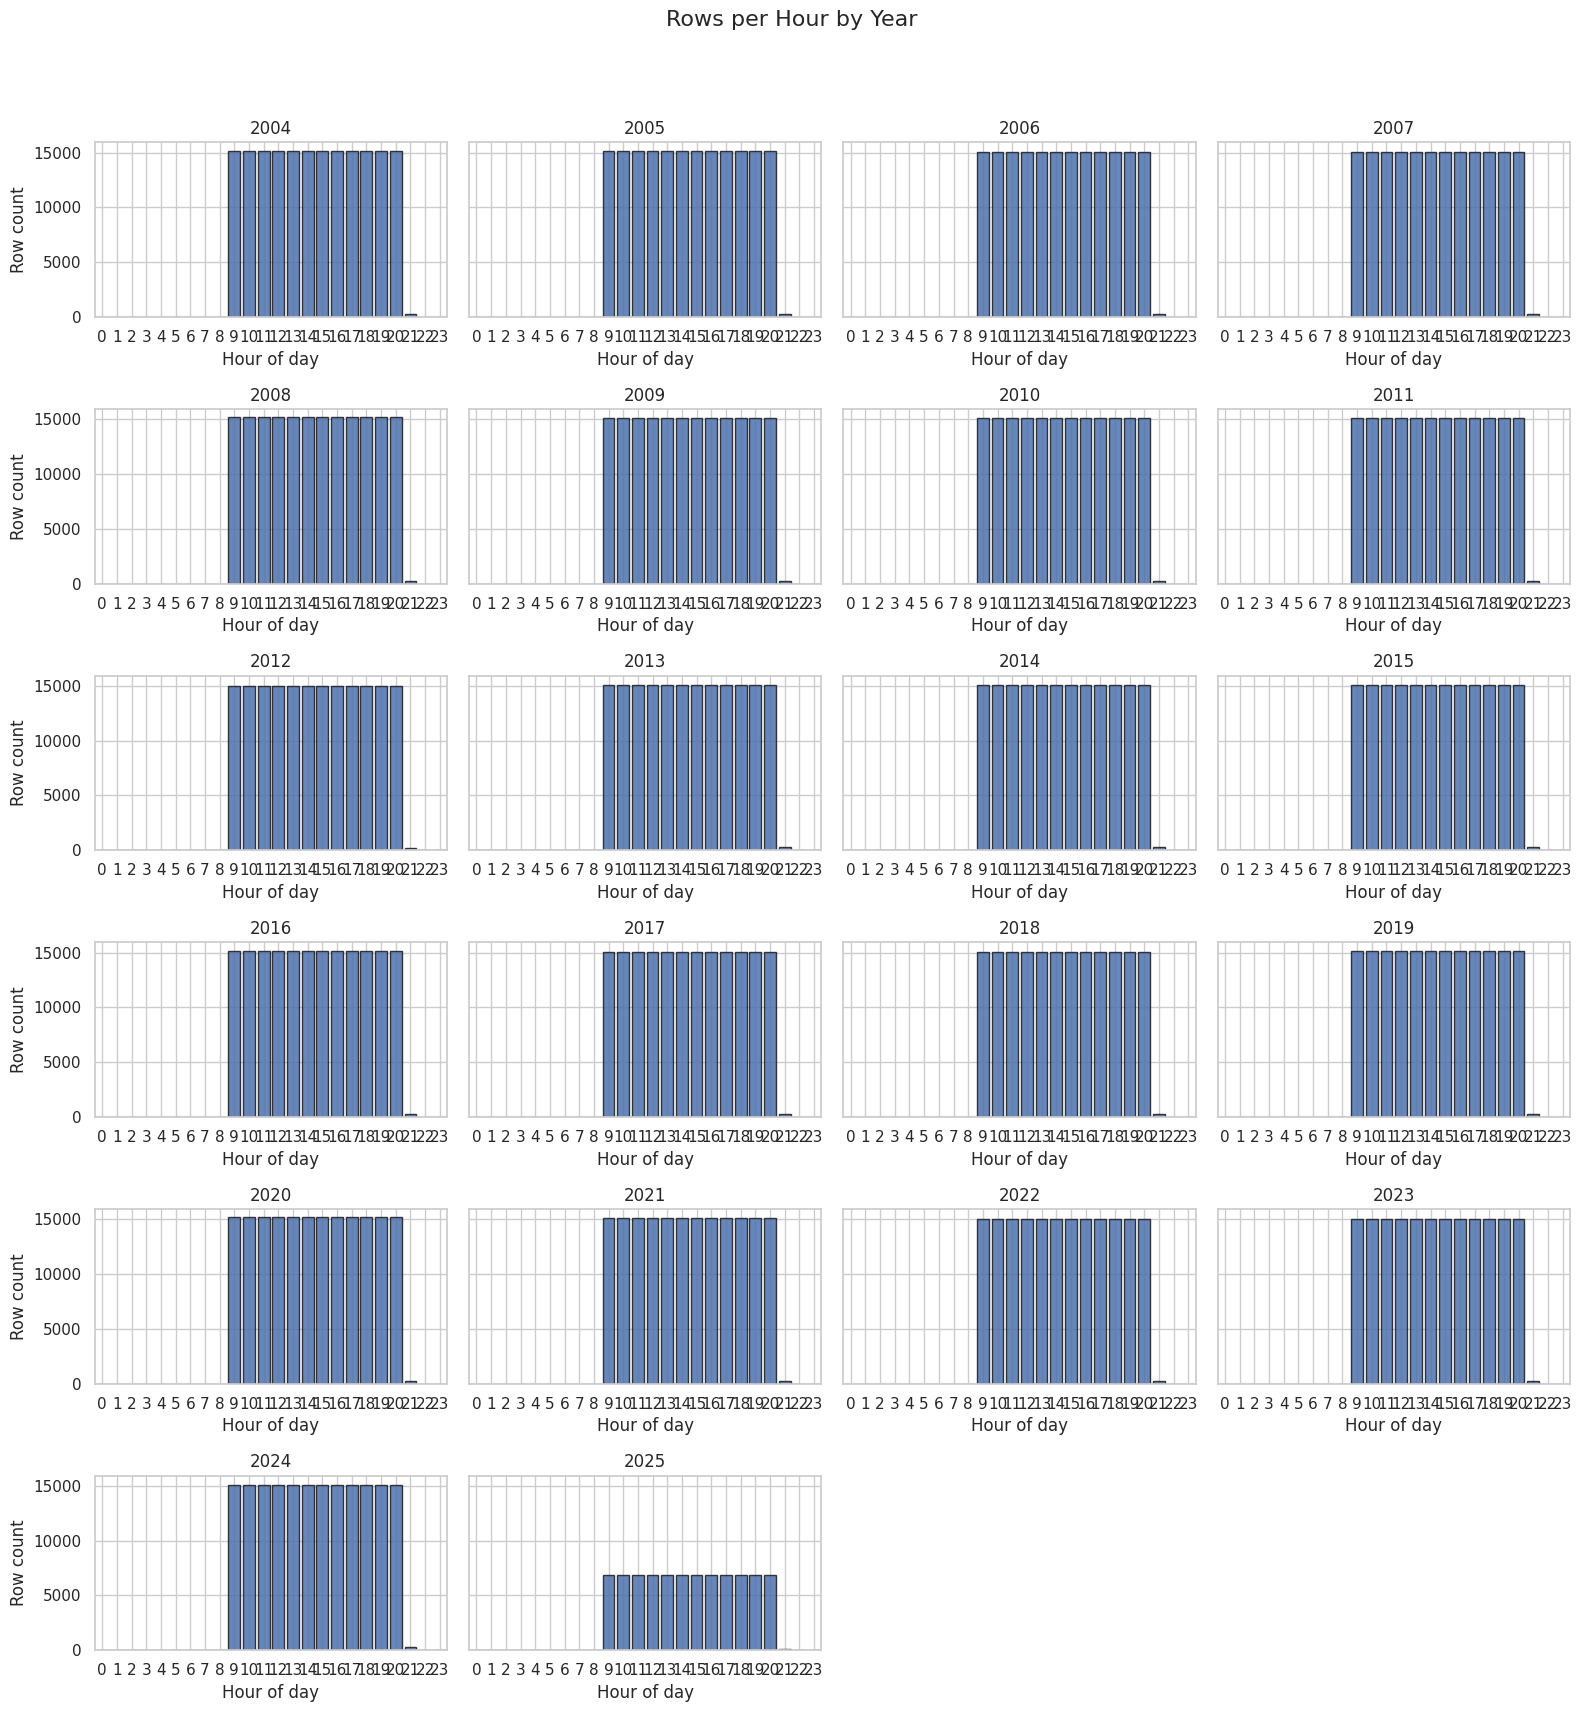

In [6]:
# Group by year and hour and plot one bar chart per year

# Ensure index is datetime
df = df.copy()
if not pd.api.types.is_datetime64_any_dtype(df.index):
    df.index = pd.to_datetime(df.index)

# Compute counts per year/hour
counts = df.groupby([df.index.year, df.index.hour]).size().unstack(fill_value=0)  # rows: year, cols: hour 0..23

years = counts.index.tolist()
n_years = len(years)

# Layout: choose grid close to square
ncols = min(4, max(1, int(math.ceil(math.sqrt(n_years)))))
nrows = int(math.ceil(n_years / ncols))

sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows), sharey=True)
axes = axes.flatten() if n_years > 1 else [axes]

# Determine a common y limit for consistent comparison
ymax = counts.values.max() if counts.size else 1

for ax_idx, year in enumerate(years):
    ax = axes[ax_idx]
    row = counts.loc[year]
    hours = list(range(24))
    vals = [int(row.get(h, 0)) for h in hours]
    ax.bar(hours, vals, color="C0", edgecolor="k", alpha=0.85)
    ax.set_title(str(year))
    ax.set_xlabel("Hour of day")
    ax.set_xticks(hours)
    ax.set_xlim(-0.5, 23.5)
    ax.set_ylim(0, ymax * 1.05)
    if ax_idx % ncols == 0:
        ax.set_ylabel("Row count")

# Turn off any unused subplots
for j in range(len(years), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Rows per Hour by Year", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
